In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter_ns
import math
import os

In [ ]:
class Descent:
  def __init__(self, obj, grad, hess):
    self.obj = obj
    self.grad = grad
    self.hess = hess

    self.X0 = None
    self.Xmin = None
    self.f_values = None
    self.stepSizeFunc = None
    # for Armijo
    self.s = None
    self.beta = None
    self.sigma = None
    # for constant step size
    self.step_size = None
    # for diminishing step size
    self.diminPower = None

  def Armijo(self, X0, d_obj, itr):
    dr = -d_obj
    inner = np.inner(d_obj,dr)[0][0]
    rhs = lambda x: self.sigma*x*inner
    lhs = lambda x: self.obj(X0+x*dr)-self.obj(X0)
    alpha =self.s
    while 1:
      l = lhs(alpha)
      r = rhs(alpha)
      if l<=r:
        break;
      alpha*= self.beta
    return alpha

  def ConstStepSize(self, X0, d_obj, itr):
    return self.step_size

  def DiminishingStep(self, X0, d_obj, itr):
    reduce = 0.0005
    alpha = (reduce/itr) ** self.diminPower
    return alpha

  def determineDiminishingStep(self,dimin="linear"):
    if (dimin.lower() == "linear"):
      self.diminPower = 1
    elif(dimin.lower() == "sqr"):
      self.diminPower = 2
    elif(dimin.lower() == "root"):
      self.diminPower = (1/2)
    else:
      raise Exception("The stepsize should be one of {'linear','sqr','root'}")


  def determineStep(self,step_rule="const",dimin="linear"):
    if (step_rule.lower() == "const"):
      self.stepSizeFunc = self.ConstStepSize
    elif (step_rule.lower() == "armijo"):
      self.stepSizeFunc = self.Armijo
    elif (step_rule.lower() == "dimin"):
      self.stepSizeFunc = self.DiminishingStep
      self.determineDiminishingStep(dimin)
    else:
      raise Exception("The stepsize should be one of {'const','armijo','dimin'}")

  def Steepest(self ,X0 ,itr = 100000 ,precision = 10**-5, step_rule="const", step_size = 0.015, s=1,beta=0.05,sigma=0.1, dimin="linear", show_progress=False, algo=None):
    """
    Parameters: X0 - vector
    Staring point of the algorithm,
    Optional Parameters:
    itr - Integer, number of Iterations, default = 100000
    Precision - float, for the stopping condition of the algorithm, default = 10**-5
    step_rule - {'const','armijo','dimin'}, the step size algorithm which are to be used, default-'const'
    step_size - float, Step size for constant integer, default=0.015
    s, beta, sigma - float, for Armijo's algorithm, default: s=1,beta=0.05,sigma=0.1
    dimin - {'linear','sqr','root'}, required for diminishing step algorithm, default='linear'
    show_progress - Boolean, if true it show the progress of the value of the cost function for every 10^n iterations

    Returns:
    Xr_1 - vector,the final vector obtained from the algorithm
    f_value - vector,the progression of objective function array
    """
    # assigning values
    self.X0 = X0.copy()
    self.step_size = step_size
    self.s = s
    self.beta = beta
    self.sigma = sigma
    # to determine the rule which was passed
    self.determineStep(step_rule, dimin)
    f_values = []
    t_arr = [0]
    Xr = self.X0
    Xr_1 = self.X0
    converge = True
    f_values.append(self.obj(Xr))
    t_start = perf_counter_ns()
    for i in range(itr):
      Xr = Xr_1
      dr = - self.grad(Xr)
      alpha = self.stepSizeFunc(Xr, -dr, (i+1))
      Xr_1 = Xr + alpha*dr
      f_values.append(self.obj(Xr_1))
      t_end = perf_counter_ns()
      t_arr.append((t_end-t_start)/10000)
      if i!=0:
        if(show_progress and (math.log(i, 10).is_integer())):
          print(f"cost function at itr={i} is {f_values[i]}")

        if(i>1000 and (f_values[i]>f_values[0])):
          converge = False
          break;

        if(f_values[i] == float('inf')):
          converge = False
          break

        if (np.linalg.norm(dr) <= precision):
          break;
    self.Xmin = Xr_1
    self.f_values = f_values
    return Xr_1, f_values, converge,(i+1), t_arr

#Utils Functions

In [ ]:
def loadParameters(A):
  row,col = A.shape
  shape = A.shape
  Abar = np.zeros(shape)
  for i in range(col-1):
    Abar[:,i] = A[:,i+1]
  #we are removing the last column cause it is labels and we will add the 1's row
  Abar[:,col-1]= np.ones((row,))
  # labels
  b = np.zeros((row,1))
  for i in range(row):
    if(A[i,0] == 1):
      b[i,0] = 1
    else:
      b[i,0] = -1
  return Abar, b, shape

def plot_scatter(A):
  row,col = A.shape
  p1 =[]
  p2 = []
  for i in range(row):
    if A[i,0]==1:
      p1.append(A[i])
    else:
      p2.append(A[i])
  p1 = np.array(p1)
  p2 = np.array(p2)
  plt.scatter(p2[:,1],p2[:,2],color="blue",marker="x",label="not 1")
  plt.scatter(p1[:,1],p1[:,2],color="red",marker="x",label="1")
  plt.legend(loc='lower left')
  plt.xlabel("Intensity")
  plt.ylabel("Symmetry")


def LinearerrorRate(Abar, Xmin, b):
  row,col = Abar.shape
  error=0
  for i in range(row):
    temp = np.reshape(Abar[i,:],(3,1))
    if(temp.T @ Xmin > 0):
      decision = 1
    else:
      decision = -1
    if (decision != b[i]):
      error+=1
  error_rate = error/row
  return error_rate*100

def LogisticErrorRate(Abar,b,x):
  train_x = np.array(x)
  train_pred = Abar @ train_x
  prob = np.exp(train_pred) / (1 + np.exp(train_pred))
  err = 0
  data_size = Abar.shape[0]
  for i in range(data_size):
    p = prob[i][0]
    if((p > 0.5) and (b[i] == -1)):
      err+=1;
    elif((p <= 0.5) and (b[i] == 1)):
      err+=1;
  err_percent = (err/data_size)*100
  return err_percent

#Visualizing Data

##Training Data

In [ ]:
from google.colab import drive
import os

In [ ]:
#getting the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/nlo/as-3/handwriting data")
%ls

 ComputeFeaturesMatlabCode.zip  'handwriting data'/     PlotImageCodeMatlab.zip
 features_test.txt               info.txt               raw_data/
 features_train.txt              PlotImageCodeMatlab/   read_plot.m


In [ ]:
A = np.loadtxt("features_train.txt",dtype = 'float64') # Loading the training data extracted from MNIST Dataset
Abar,b,(row,col) = loadParameters(A)

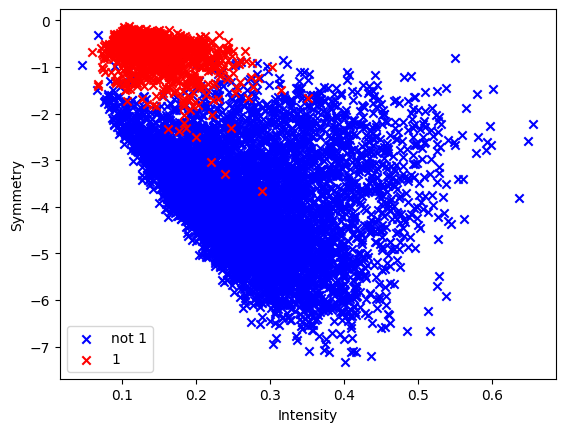

In [ ]:
plot_scatter(A)

##Testing Data

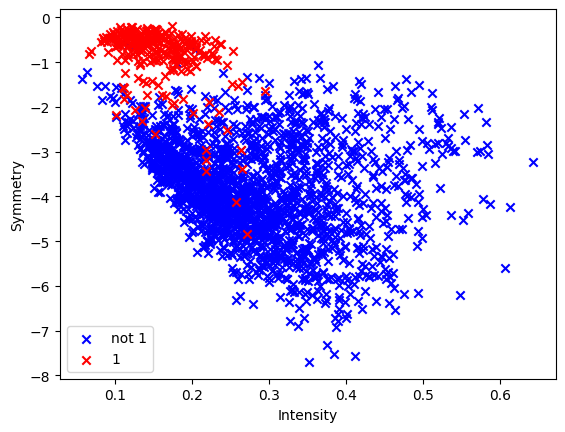

In [ ]:
A_test = np.loadtxt("features_test.txt",dtype = 'float64') # Loading the testing data extracted from MNIST Dataset
Abar_test,b_test,(row_test,col_test) = loadParameters(A_test)
plot_scatter(A_test)

#Linear Regression

In [ ]:
obj = lambda x: 0.5*(np.linalg.norm(Abar @ x - b)**2)
grad = lambda x: Abar.T @ (Abar @ x - b)
hess = lambda x: Abar.T @ Abar
x_old = np.zeros((3, 1))
L = np.linalg.norm(Abar.T @ Abar)

In [ ]:
k1 = Abar.T @ b
k2 = Abar.T @ Abar
k2 = np.linalg.inv(k2)
k = (k2 @ k1)
minima = obj(k)
minima

820.7766312753236

obtained minima is 820.7766312753247, exact minima is 820.7766312753236 with step_size = 1.3970351791567246e-05 in 23891 iterations
obtained minima is 820.7766312753247, exact minima is 820.7766312753236 with step_size = 9.31356786104483e-06 in 35840 iterations


[]

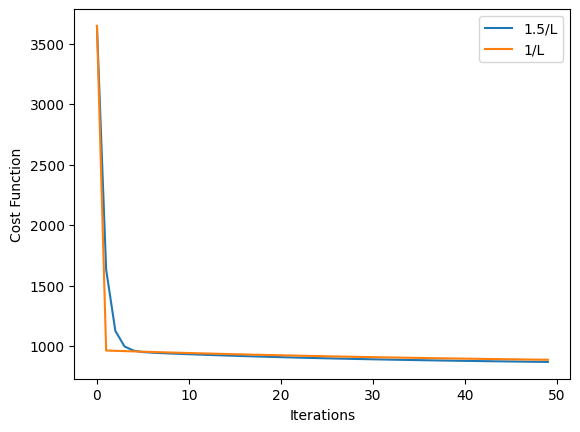

In [ ]:
regress_const = Descent(obj,grad,hess)
const_arr = [(1.5/L),(1/L)]
for step in const_arr:
  x_min_1_l_const_linear, f_values_amnist_const, converge, itr, t_array_linear= regress_const.Steepest(x_old, step_rule="const",step_size=step)
  f_values_amnist_const = np.array(f_values_amnist_const)
  if(converge):
    print(f"obtained minima is {obj(x_min_1_l_const_linear)}, exact minima is {minima} with step_size = {step} in {itr} iterations")
    plt.plot(f_values_amnist_const[0:50])
  else:
    plt.plot(f_values_amnist_const[0:3])

plt.legend(["1.5/L","1/L"])
plt.xlabel("Iterations")
plt.ylabel("Cost Function")
plt.plot()

###Fitting the line got to the training data

Text(0.5, 1.0, 'fitted line, constant stepsize rule, alpha = 1/L')

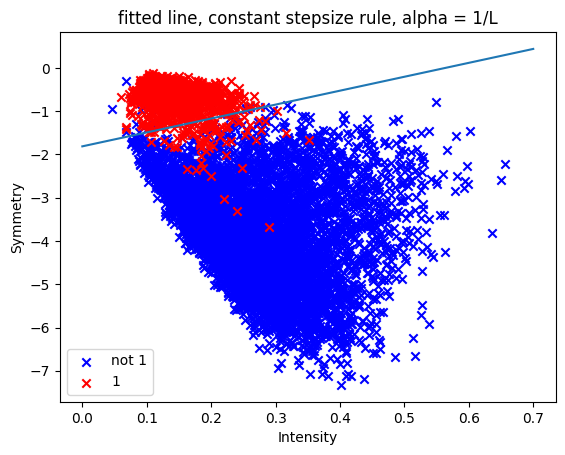

In [ ]:
plot_scatter(A)
a_1 = np.arange(0,0.8,0.1)
a_2_const = -((x_min_1_l_const_linear[0]/x_min_1_l_const_linear[1])*a_1 + (x_min_1_l_const_linear[2]/x_min_1_l_const_linear[1]))
plt.plot(a_1,a_2_const)
plt.title("fitted line, constant stepsize rule, alpha = 1/L")

###Predicting using Testing data

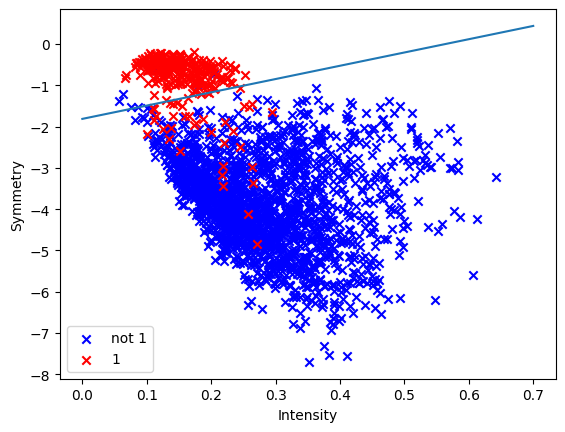

In [ ]:
plot_scatter(A_test)
plt.plot(a_1,a_2_const)

####Finding Error rate

In [ ]:
test_error_const = LinearerrorRate(Abar_test,x_min_1_l_const_linear, b_test)
train_error_const = LinearerrorRate(Abar,x_min_1_l_const_linear, b)
print(f"error rate using Constant step-size rule with step-size (1/L) on testing data is {test_error_const}")
print(f"error rate using Constant step-size rule with step-size (1/L) training data is {train_error_const}")

error rate using Constant step-size rule with step-size (1/L) on testing data is 2.29197807673144
error rate using Constant step-size rule with step-size (1/L) training data is 1.5224249074201068


#Logistic Regression

In [ ]:
L = 0
M = Abar.shape[0]
for i in range(M):
  L += (np.linalg.norm(Abar[i,:]) ** 2)
L /= M

##Objective function and its Gradient

In [ ]:
def obj_logistic(X):
  M = Abar.shape[0]
  sum=0
  for i in range(M):
    sum += np.log(1+np.exp(- b[i,:].reshape(1,1) @ X.T @ (Abar[i,:].reshape(1,3).T) ))
  sum/=M

  return np.linalg.norm(sum);

def grad_logistic(X):
  M, N = Abar.shape
  grad = np.zeros((N,1))
  for i in range(M):
    d = (1+np.exp(b[i,:].reshape(1,1)  @ X.T @(Abar[i,:].reshape(1,3).T)))
    grad += (b[i,:].reshape(1,1) @ Abar[i,:].reshape(1,3)).T / d
  grad /= -M
  return grad

[[0.09978843]
 [2.45225674]
 [3.0420121 ]]
[[0.10161377]
 [2.11137542]
 [2.43866377]]


[]

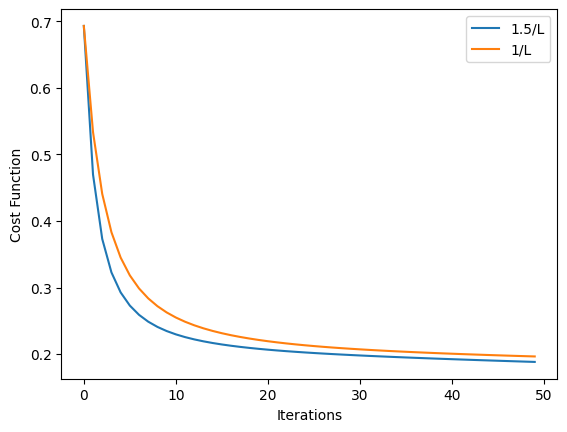

In [ ]:
regress_const = Descent(obj_logistic,grad_logistic,hess)
const_arr = [1.5/L, 1/L]
for step in const_arr:
  x_min_1_l_const, f_values_amnist_const, converge, itr, t_array_log= regress_const.Steepest(x_old, step_rule="const",step_size=step, itr=1200)
  f_values_amnist_const = np.array(f_values_amnist_const)
  print(x_min_1_l_const)
  if(converge):
    # print(f"obtained minima is {obj_logistic(x_min_1_l_const)}, exact minima is {minima} with step_size = {step} in {itr} iterations")
    plt.plot(f_values_amnist_const[0:50])
  else:
    plt.plot(f_values_amnist_const[0:3])

plt.legend(["1.5/L","1/L"])
plt.xlabel("Iterations")
plt.ylabel("Cost Function")
plt.plot()

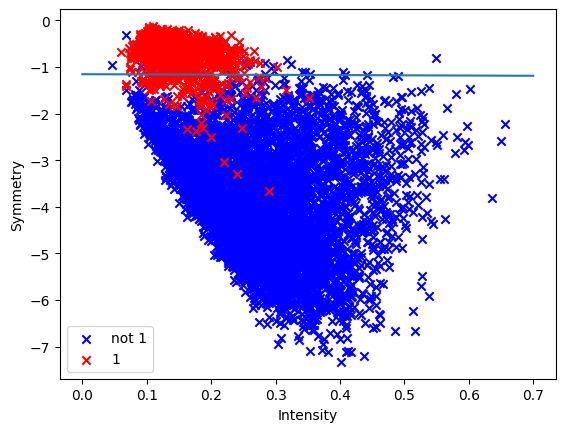

In [ ]:
a_1 = np.arange(0,0.8,0.1)
a_2_const = -((x_min_1_l_const[0]/x_min_1_l_const[1])*a_1 + (x_min_1_l_const[2]/x_min_1_l_const[1]))
# lets generate the line Ax+b
plot_scatter(A)
plt.plot(a_1,a_2_const)

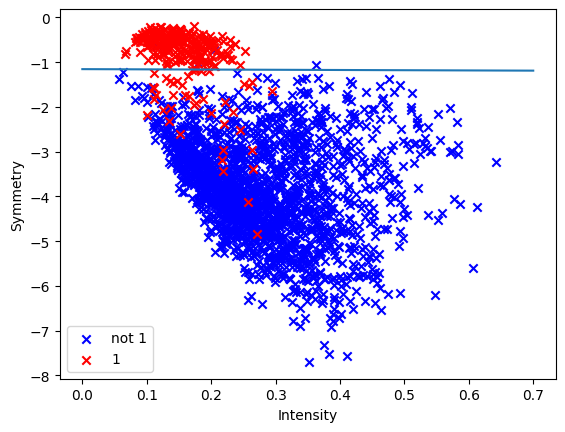

In [ ]:
plot_scatter(A_test)
plt.plot(a_1,a_2_const)

In [ ]:
test_error_const = LogisticErrorRate(Abar_test,b_test,x_min_1_l_const)
train_error_const = LogisticErrorRate(Abar,b,x_min_1_l_const)
print(f"error rate using Constant step-size rule for Logistic Regression with step-size (1/L) on testing data is {test_error_const}")
print(f"error rate using Constant step-size rule for Logistic Regression with step-size (1/L) training data is {train_error_const}")

error rate using Constant step-size rule for Logistic Regression with step-size (1/L) on testing data is 2.3418036870951666
error rate using Constant step-size rule for Logistic Regression with step-size (1/L) training data is 2.0847620353860923


#Perceptron Algorithm

In [ ]:
def obj_percep(X):
  M = Abar.shape[0]
  sum=0
  for i in range(M):
    sum += np.maximum((-b[i,:].reshape(1,1) @ X.T @ (Abar[i,:].reshape(1,3).T)), [0])

  return np.linalg.norm(sum);

In [ ]:
def grad_percep(X):
  M, N = Abar.shape
  grad = np.zeros((N,1))
  for i in range(M):
    k = - b[i,:].reshape(1,1) @ X.T @ (Abar[i,:].reshape(1,3).T)
    if( k > 0):
      grad += (-b[i,:].reshape(1,1) @ Abar[i,:].reshape(1,3)).T
  return grad

[]

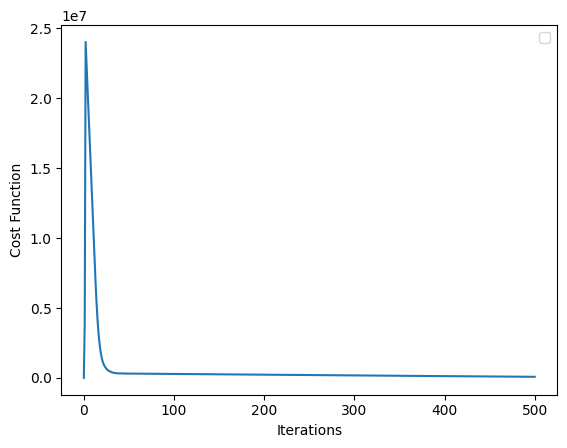

In [ ]:
x_one = np.ones((3,1))
regress_const = Descent(obj_percep,grad_percep,hess)
const_arr = [1]
for step in const_arr:
  x_min_1_l_const_percep, f_values_amnist_const, converge, itr,t_percep= regress_const.Steepest(x_one, step_rule="const",step_size=step, itr=500,algo = "percep")
  f_values_amnist_const = np.array(f_values_amnist_const)
  if(converge):
    plt.plot(f_values_amnist_const)
  else:
    plt.plot(f_values_amnist_const[0:3])

plt.legend([])
plt.xlabel("Iterations")
plt.ylabel("Cost Function")
plt.plot()

##Plotting the Separating Line

##Comments on Perceptron

Since our data is not exactly linearly seperable the perceptron algorithm initially increases then starts to decrease

###Training Data

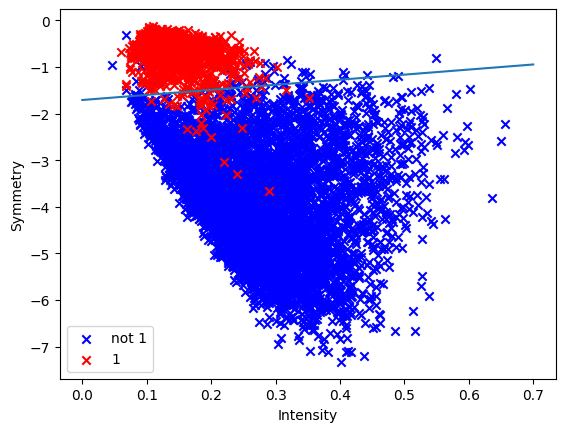

In [ ]:
a_1 = np.arange(0,0.8,0.1)
a_2_const = -((x_min_1_l_const_percep[0]/x_min_1_l_const_percep[1])*a_1 + (x_min_1_l_const_percep[2]/x_min_1_l_const_percep[1]))
# lets generate the line Ax+b
plot_scatter(A)
plt.plot(a_1,a_2_const)

###Testing Data

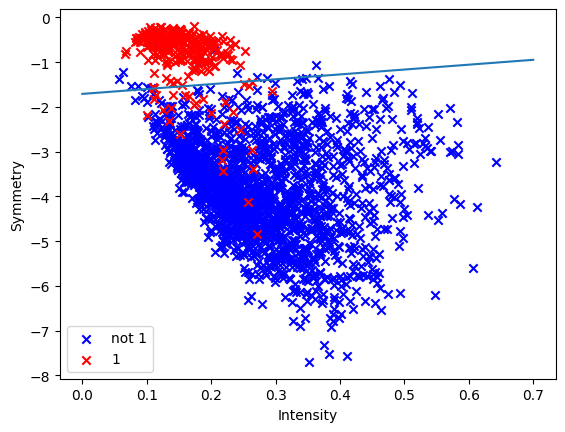

In [ ]:
plot_scatter(A_test)
plt.plot(a_1,a_2_const)

#SVD

In [ ]:
class LagrangianSolver():
  def __init__(self,LB,UB):
    self.LB = LB
    self.UB = UB
  def CoordinateDes(self, x ,y, maxItr=20):
    shape = x.shape
    lamda = np.zeros((shape[0],1))
    for i in range(maxItr):
      print(f"iteration:{i}")
      for coor in range(shape[0]):
        # print(coor)
        grad = self.grad(x,y,lamda, coor)
        step_size_inverse = (y[coor]**2) * (np.linalg.norm(x[coor,:])**2)
        temp = lamda[coor] + grad*(1/step_size_inverse)
        lamda[coor] = np.maximum(np.minimum(temp,self.UB),self.LB)
      print(lamda)
    return lamda

  def grad(self,x,y,lamda, coor):
    m,n = x.shape
    temp = np.zeros((1,n))
    for i in range(m):
      if(lamda[i]!=0):
        temp += lamda[i]*y[i]*x[i,:]
    return (1- y[coor]*x[coor,:]@temp.T)




In [ ]:
c=100
lagrangian = LagrangianSolver(0,c)
lamda = lagrangian.CoordinateDes(Abar,b, maxItr=10)

iteration:0
[[0.04623718]
 [0.        ]
 [0.03682012]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
iteration:1
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
iteration:2
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
iteration:3
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
iteration:4
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
iteration:5
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
iteration:6
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
iteration:7
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
iteration:8
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
iteration:9
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
x = np.zeros((3))
for i in range(Abar.shape[0]):
  x+= b[i]*lamda[i]*Abar[i,:]

In [ ]:
a_1 = np.arange(0,0.8,0.1)
a_2_const = -((x[0]/x[1])*a_1 + (x[2]/x[1]))

Text(0.5, 1.0, 'fitting the SVM Classifier line for Training data')

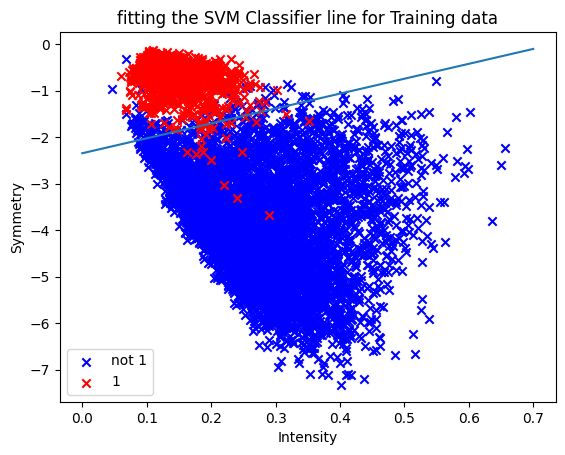

In [ ]:
plot_scatter(A)
plt.plot(a_1,a_2_const)
plt.title("fitting the SVM Classifier line for Training data")

In [ ]:
def SVMErrorRate(Abar,b,x):
  shape = Abar.shape
  error=0
  side=-1
  for i in range(shape[0]):
    if(Abar[i,:]@x >=0):
      side = 1
    else:
      side=-1
    if(side != b[i]):
      error+=1
  percentage_error = (error/shape[0])*100
  return percentage_error

In [ ]:
Train_error = SVMErrorRate(Abar,b,x)
print(f"Train error using SVM is {Train_error}%")

Train error using SVM is 1.796735701549856%


Text(0.5, 1.0, 'fitting the SVM Classifier line for Testing data')

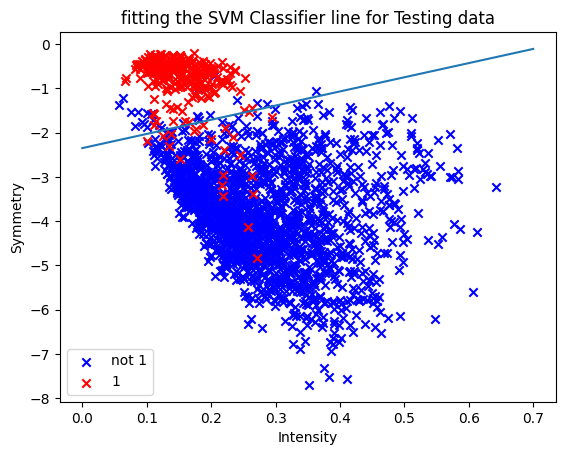

In [ ]:
plot_scatter(A_test)
plt.plot(a_1,a_2_const)
plt.title("fitting the SVM Classifier line for Testing data")

In [ ]:
Test_error = SVMErrorRate(Abar_test,b_test,x)
print(f"Test error using SVM is {Test_error}%")

Test error using SVM is 2.391629297458894%
